In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from evaluateModel import evaluate_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
import pickle

In [2]:
# 1. Obtener un set de datos.
df = pd.read_csv("alzheimers_disease_data.csv")

# 2. Buscar valores vacios
print("Missing values:")
print(df.isna().sum())

# 3. Eliminar columnas que no agrega valor al entrenamiento
df = df.drop('PatientID', axis=1)
df = df.drop('DoctorInCharge', axis=1)

print("\nDistribución original de clases:")
print(df['Diagnosis'].value_counts(normalize=True) * 100)

Missing values:
PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTas

In [3]:
# Guardar las columnas por normalizar
numerical_cols = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "DietQuality", "SleepQuality", "SystolicBP", "DiastolicBP", "CholesterolTotal", "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides", "MMSE", "FunctionalAssessment", "ADL"]

# Guardar las columnas numéricas
categorical_cols = ["Gender", "Ethnicity", "EducationLevel", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease", "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints", "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks", "Forgetfulness"]

In [4]:
# 4. Separar features y target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [5]:
X_train_val, X_external, y_train_val, y_external = train_test_split(X, y, test_size=0.1, random_state=42)

external_data = pd.concat([X_external, y_external], axis=1)
external_data.to_csv("datos_externos.csv", index=False)

In [6]:
# 5. Dividir en train y test con un split 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [7]:
# 6. Aplicar las técnicas de escalamiento y transformación de datos
# Transformar datos categóricos mediante One Hot Encoder
encoder = OneHotEncoder(sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_cat_encoded = encoder.transform(X_test[categorical_cols])

# Escalamiento de datos numéricos mediante StandarScaler
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_num_scaled = scaler.transform(X_test[numerical_cols])

In [8]:
# 7. Obtener nombres de features
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Crear DataFrames para datos categóricos transformados
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_feature_names)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_feature_names)

# Crear DataFrames para datos numéricos transformados
X_train_num_df = pd.DataFrame(X_train_num_scaled, columns=numerical_cols)
X_test_num_df = pd.DataFrame(X_test_num_scaled, columns=numerical_cols)

In [9]:
# 8. Combinar datos categóricos y numéricos
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

In [10]:
# 9. Transformar target a valor numerico mediante LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_encoded)

In [12]:
# 4. Selección de características con F-Score y Grid Search para el umbral óptimo

# Calcular F-scores de todas las características
selector_all = SelectKBest(f_classif, k='all')
selector_all.fit(X_train_resampled, y_train_resampled)
feature_scores = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'F-Score': selector_all.scores_
})
feature_scores = feature_scores.sort_values('F-Score', ascending=False)

# Definir los valores a probar para el número de características
k_values = list(range(5, min(51, X_train_resampled.shape[1]), 5))  # De 5 a 50 de 5 en 5
best_score = 0
best_k = 0

# Buscar el mejor valor de k mediante validación cruzada
for k in k_values:
    # Crear selector con k características
    temp_selector = SelectKBest(f_classif, k=k)
    X_train_k = temp_selector.fit_transform(X_train_resampled, y_train_resampled)
    
    # Evaluar con validación cruzada
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_k, y_train_resampled, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    
    print(f"k={k}, score={mean_score:.4f}")
    
    # Actualizar mejor k si el score es mayor
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"\nMejor número de características encontrado: {best_k}")
print(f"Mejor score de validación cruzada: {best_score:.4f}")

# Aplicar la selección final con el mejor k
selector = SelectKBest(f_classif, k=best_k)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test_processed)

# Obtener nombres de las características seleccionadas
selected_features = X_train_processed.columns[selector.get_support()]
print(f"\nSeleccionadas {len(selected_features)} características:")
print(feature_scores[feature_scores['Feature'].isin(selected_features)].sort_values('F-Score', ascending=False))

k=5, score=0.8921
k=10, score=0.9516
k=15, score=0.9471
k=20, score=0.9481
k=25, score=0.9486
k=30, score=0.9506
k=35, score=0.9426
k=40, score=0.9381
k=45, score=0.9416
k=50, score=0.9496

Mejor número de características encontrado: 10
Mejor score de validación cruzada: 0.9516

Seleccionadas 10 características:
                 Feature     F-Score
13  FunctionalAssessment  357.448970
14                   ADL  305.276057
40    MemoryComplaints_1  214.382092
39    MemoryComplaints_0  214.382092
12                  MMSE  159.409317
41  BehavioralProblems_0   74.337197
42  BehavioralProblems_1   74.337197
43           Confusion_0   12.513076
44           Confusion_1   12.513076
5           SleepQuality   10.022251


In [13]:
# 5. Entrenar modelos base
dt_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)
nb_model = GaussianNB()
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier()

In [14]:
# Lista de modelos
base_models = [
    ('DT', dt_model),
    ('SVM', svm_model),
    ('NB', nb_model),
    ('LR', lr_model),
    ('RF', rf_model)
]

# Entrenar y evaluar cada modelo base con validación cruzada
for name, model in base_models:
    cv_scores = cross_val_score(model, X_train_selected, y_train_resampled, cv=5, scoring='accuracy')
    print(f"{name}: Accuracy = {cv_scores.mean():.4f}, Desviación =  {cv_scores.std():.4f}")
    model.fit(X_train_selected, y_train_resampled)

DT: Accuracy = 0.9181, Desviación =  0.0234
SVM: Accuracy = 0.9101, Desviación =  0.0156
NB: Accuracy = 0.7502, Desviación =  0.0472
LR: Accuracy = 0.8402, Desviación =  0.0139
RF: Accuracy = 0.9536, Desviación =  0.0134


In [15]:
# 6. Crear el modelo de ensamble 
voting_model = VotingClassifier(estimators=base_models, voting='hard')
voting_model.fit(X_train_selected, y_train_resampled)

VotingClassifier(estimators=[('DT', DecisionTreeClassifier(random_state=42)),
                             ('SVM', SVC(probability=True, random_state=42)),
                             ('NB', GaussianNB()),
                             ('LR', LogisticRegression(random_state=42)),
                             ('RF', RandomForestClassifier(max_depth=13))])

In [16]:
# 7. Evaluar el modelo de ensamble
y_pred = voting_model.predict(X_test_selected)

In [17]:
# 8. Evaluación completa y comparación de modelos
print("\n8. Evaluación completa y comparación de modelos")

results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Sensitivity': [],
    'Specificity': [],
    'F1-Score': [],
    'MCC': [],
    'AUC-ROC': []
}

roc_curves = []


8. Evaluación completa y comparación de modelos


In [18]:
# Evaluar cada modelo base
for name, model in base_models:
    print(f"\nEvaluación de {name}")
    model.fit(X_train_selected, y_train_resampled)
    result = evaluate_model(name, model, X_test_selected, y_test_encoded)
    results['Model'].append(name)
    results['Accuracy'].append(result['accuracy'])
    results['Precision'].append(result['precision'])
    results['Sensitivity'].append(result['sensitivity'])
    results['Specificity'].append(result['specificity'])
    results['F1-Score'].append(result['f1'])
    results['MCC'].append(result['mcc'])
    results['AUC-ROC'].append(result['auc'])
    if 'fpr' in result:
        roc_curves.append(result)


Evaluación de DT

Matriz de confusión para DT:
          label neg   label pos
pred neg     226          21
pred pos     20          120
Accuracy: 0.8941
AUC-ROC: 0.8849

Evaluación de SVM

Matriz de confusión para SVM:
          label neg   label pos
pred neg     219          15
pred pos     27          126
Accuracy: 0.8915
AUC-ROC: 0.9355

Evaluación de NB

Matriz de confusión para NB:
          label neg   label pos
pred neg     184          43
pred pos     62          98
Accuracy: 0.7287
AUC-ROC: 0.8251

Evaluación de LR

Matriz de confusión para LR:
          label neg   label pos
pred neg     197          19
pred pos     49          122
Accuracy: 0.8243
AUC-ROC: 0.9054

Evaluación de RF

Matriz de confusión para RF:
          label neg   label pos
pred neg     237          13
pred pos     9          128
Accuracy: 0.9432
AUC-ROC: 0.9472


In [19]:
# Evaluar el modelo híbrido
print("\nEvaluación del modelo Híbrido")
ensemble_result = evaluate_model('Ensemble', voting_model, X_test_selected, y_test_encoded)
results['Model'].append('Ensemble')
results['Accuracy'].append(ensemble_result['accuracy'])
results['Precision'].append(ensemble_result['precision'])
results['Sensitivity'].append(ensemble_result['sensitivity'])
results['Specificity'].append(ensemble_result['specificity'])
results['F1-Score'].append(ensemble_result['f1'])
results['MCC'].append(ensemble_result['mcc'])
results['AUC-ROC'].append(ensemble_result['auc'])
if 'fpr' in ensemble_result:
    roc_curves.append(ensemble_result)


Evaluación del modelo Híbrido

Matriz de confusión para Ensemble:
          label neg   label pos
pred neg     224          12
pred pos     22          129
Accuracy: 0.9121



Tabla de todos los modelos:
      Model  Accuracy  Precision  Sensitivity  Specificity  F1-Score  \
0        DT  0.894057   0.857143     0.851064     0.918699  0.854093   
1       SVM  0.891473   0.823529     0.893617     0.890244  0.857143   
2        NB  0.728682   0.612500     0.695035     0.747967  0.651163   
3        LR  0.824289   0.713450     0.865248     0.800813  0.782051   
4        RF  0.943152   0.934307     0.907801     0.963415  0.920863   
5  Ensemble  0.912145   0.854305     0.914894     0.910569  0.883562   

        MCC   AUC-ROC  
0  0.770942  0.884882  
1  0.771547  0.935478  
2  0.432923  0.825059  
3  0.645456  0.905380  
4  0.876744  0.947183  
5  0.814386  0.000000  


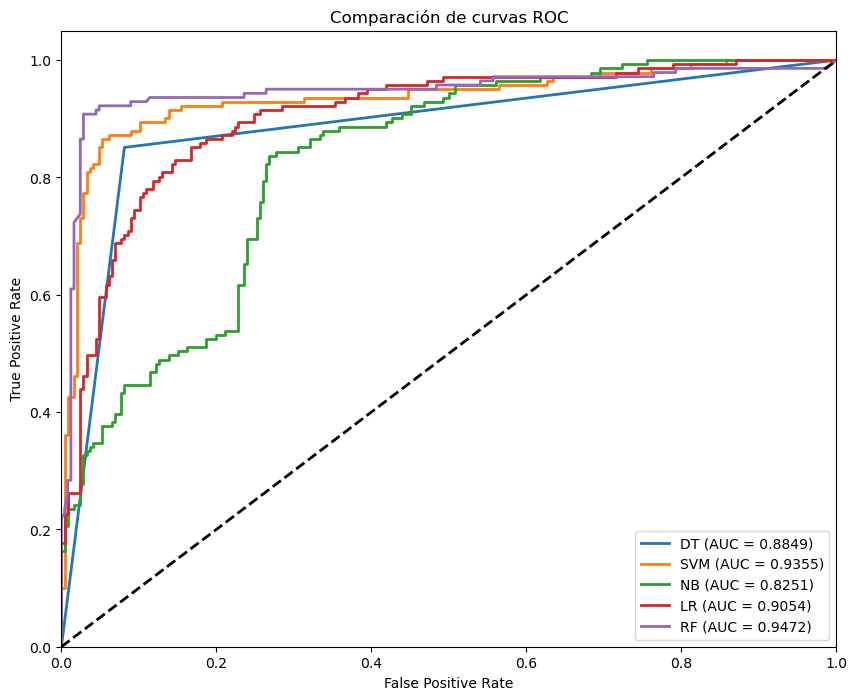

In [20]:
# Crear tabla de resultados
results_df = pd.DataFrame(results)
print("\nTabla de todos los modelos:")
print(results_df)

# Crear gráfico comparativo de curvas ROC
plt.figure(figsize=(10, 8))
for curve in roc_curves:
    plt.plot(curve['fpr'], curve['tpr'], lw=2, 
             label=f"{curve['name']} (AUC = {curve['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de curvas ROC')
plt.legend(loc="lower right")

In [21]:
components = {
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'selector': selector,
    'selected_features': selected_features,
    'model': voting_model,
}

with open('modelo_alzheimer.pkl', 'wb') as f:
    pickle.dump(components, f)